In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain.chat_models import init_chat_model
from langchain.tools import tool

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

In [21]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [22]:
def chat_agent(state: State) -> State:
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

In [23]:
builder = StateGraph(State)

builder.add_node("CHAT_AGENT", chat_agent)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "CHAT_AGENT")
builder.add_conditional_edges("CHAT_AGENT", tools_condition)
builder.add_edge("tools", "CHAT_AGENT")
builder.add_edge("CHAT_AGENT", END)

graph = builder.compile()

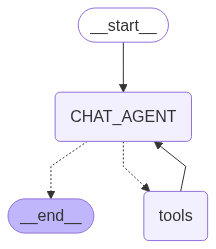

In [24]:
from IPython.display import Image, display

Image(graph.get_graph().draw_mermaid_png())

In [25]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock price right now?"}]})
print(state["messages"][-1].content)

The current price of AAPL stock is $100.4.


In [26]:
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only"}]})
print(state["messages"][-1].content)

Albert Einstein


In [27]:
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

The current price for AMZN is $150 and for MSFT is $200.3.
The total cost for 20 AMZN stocks is 20 * $150 = $3000.
The total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.
Therefore, the total cost for both is $3000 + $3004.5 = $6004.5.
